In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
path = tf.keras.utils.get_file('sunspots.csv', 
                               '  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')
print (path)

C:\Users\Amir\.keras\datasets\sunspots.csv


<AxesSubplot:xlabel='Date'>

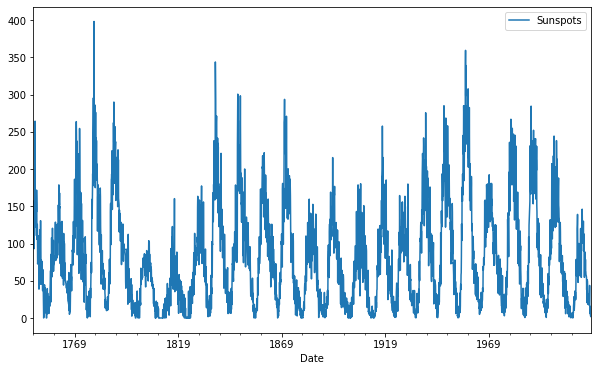

In [3]:
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.columns = ['Sunspots']   # reaname column
df.plot(figsize=(10,6))

In [4]:
df.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [5]:
print('Total months data: ' + str(len(df)) + ' years:' + str(len(df)//12))

Total months data: 3235 years:269


In [6]:
split_time = 3000

train = df[:split_time]
test = df[split_time:]

print('Total test months: ' + str(len(test)) + ' train months: ' + str(len(train)))
print('Total test years: ' + str(len(test)//12) + ' train years: ' + str(len(train)//12))

Total test months: 235 train months: 3000
Total test years: 19 train years: 250


In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [8]:
# 60 months = 5 years data for the the time window size
n_input = 60
n_features = 1
n_batch_size = 256

In [9]:
train_generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

In [10]:
x, y = train_generator[1]
print(x.shape)
print(y.shape)

(256, 60, 1)
(256, 1)


In [11]:
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_generator, epochs=10)

Epoch 1/10
12/12 [==============================] - 1s 81ms/step - loss: 0.0550: 0s - loss: 0.05
Epoch 2/10
12/12 [==============================] - 1s 97ms/step - loss: 0.0244
Epoch 3/10
12/12 [==============================] - 1s 73ms/step - loss: 0.0144
Epoch 4/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0096
Epoch 5/10
12/12 [==============================] - 1s 73ms/step - loss: 0.0071
Epoch 6/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0066
Epoch 7/10
12/12 [==============================] - 1s 76ms/step - loss: 0.0060
Epoch 8/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0057
Epoch 9/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0057
Epoch 10/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0055


In [14]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))   # stepping stone value

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0])                # predict and save in list
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1) # next value for prediction

In [15]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, 
                          columns=['Prediction'])

In [16]:
df_predict.head(2)

,Prediction
Date,
2013-08-31,117.534277
2013-09-30,121.269967


In [17]:
df_test = pd.concat([df,df_predict], axis=1)

In [18]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])) #error acceptable?

76.06570813349049

In [19]:
#df_test.plot(figsize=(14,6))

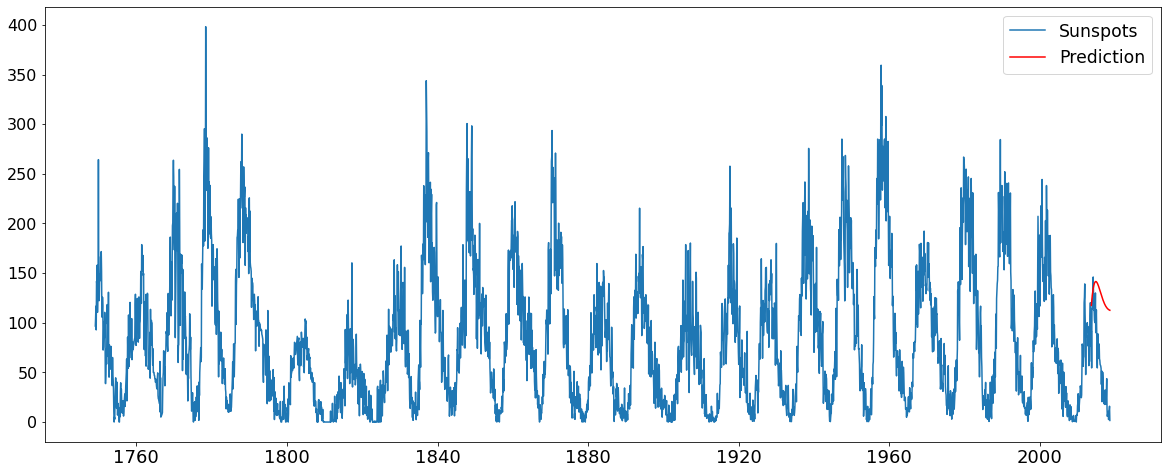

In [20]:
plt.figure(figsize=(20, 8))
plt.plot(df_test.index, df_test['Sunspots'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(["Sunspots", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [21]:
# This time train is using the full df for the future forecasting
train = df
len(train)

scaler.fit(train)
train = scaler.transform(train)

generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

In [22]:
model.fit(generator,epochs=10)

Epoch 1/10
13/13 [==============================] - 1s 70ms/step - loss: 0.0054
Epoch 2/10
13/13 [==============================] - 1s 69ms/step - loss: 0.0054
Epoch 3/10
13/13 [==============================] - 1s 68ms/step - loss: 0.0052
Epoch 4/10
13/13 [==============================] - 1s 84ms/step - loss: 0.0052
Epoch 5/10
13/13 [==============================] - 1s 80ms/step - loss: 0.0051
Epoch 6/10
13/13 [==============================] - 1s 79ms/step - loss: 0.0052
Epoch 7/10
13/13 [==============================] - 1s 82ms/step - loss: 0.0050
Epoch 8/10
13/13 [==============================] - 1s 69ms/step - loss: 0.0051
Epoch 9/10
13/13 [==============================] - 1s 69ms/step - loss: 0.0051
Epoch 10/10
13/13 [==============================] - 1s 84ms/step - loss: 0.0049


In [23]:
pred_list = []

n_future_length = 60   # 60 months 
batch = train[-n_input:].reshape((1, n_input, n_features))
batch = train[0:n_input].reshape((1, n_input, n_features))

for i in range(n_future_length):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [24]:
from pandas.tseries.offsets import DateOffset

add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0, n_future_length + 1) ]
future_dates = pd.DataFrame(index = add_dates[1:],
                            columns = df.columns)
len(future_dates)

60

In [25]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_future_length:].index, 
                          columns=['Prediction'])

In [26]:
df_projected = pd.concat([df,df_predict], axis=1)

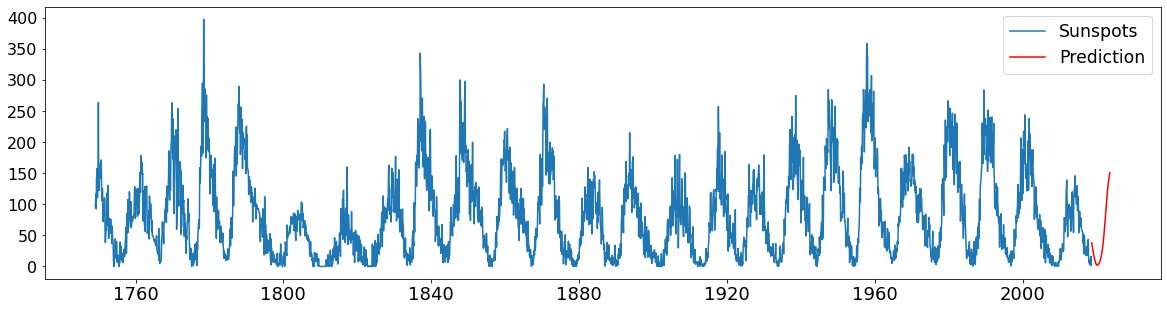

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(df_projected.index, df_projected['Sunspots'])
plt.plot(df_projected.index, df_projected['Prediction'], color='r')
plt.legend(["Sunspots", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()